# **KAGGLE** : **sureshghatani**

# **Introduction**

This notebook is for the major project submission for COMP8220, on the dataset of human faces, consists of 100 * 100 dimensional images, which are mostly coloured images. 

The task is to predict the age group of the person whose face is in the image using two separate approaches: conventional machine learning and deep learning method. 




Overall, it contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.




### **Pre-setup:** 

Connect google drive to google colab

In [48]:
# import and drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Conventional Machine Learning approach:**

First, different traditional model approach was explored using the library *sklearn* for feature extraction. 

A. SVM

B. Random Forest Classifier



### **Explore the Dataset:**

### **Import necessary libraries**

In [49]:
# Import required libraries

import numpy as np
from skimage.feature import hog
from skimage import io
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 


import matplotlib.pyplot as plt

#### **Preprocess Label data with Image Id and Exact Age**

In [50]:
def age_and_id(y_data):
  '''Returns age and label from y data.
  The output data have imageid and age in a same line as '12345-81'.
  Separate the image id and exact age
  Parameters:
  y_data (array) : it is an array of multiple images
  Returns:
  ages (array) : Separated age after characetr '-'
  labels (array) : Separated label after character '-'
  '''
  ages = []
  labels =[]
  for y in y_data:
    if y[-2:][0] == '-':
      age = y[-1:]
      label = y[:-2]
    else:
      age = y[-2:]
      label = y[:-3]
    ages.append(age)
    labels.append(label)
  return ages, labels


#### **Preprocess to find Age Bucket**

In this section, different age groups are divided into three groups and stored in a respective bucket 

* For ages in between  6-20 , bucket 0.
* For ages in between  35 to 40 , bucket 1.
* For ages in between 55 to 98  , bucket 2.

In [51]:
# Defining a function to return the class labels bucket corresponding to the age-ranges shown above.

def create_bucket(age_grps):
  '''
  The age are exact ages, for classification bucketing is needed for groups.\
  For ages in between  6-20 , bucket 0.
  For ages in between  35 to 40 , bucket 1.
  For ages in between 55 to 98  , bucket 2.
  Paramters:
  age_grps (array) : Exact age according to image
  Returns :
  buckets (array) : Bucketing of age 
  '''
  buckets = []
  for y in age_grps:
    if int(y) < 21:
      age_bucket=0
    elif 41 > int(y) > 34:
      age_bucket=1
    else:
      age_bucket = 2
    buckets.append(age_bucket) 
  return buckets 

#### **Function to load npy data**

In [52]:
# Load and read the npy data
def read_npy_data(path_to_data):
  '''
  Returns the data loaded from npy file.
  Parameters:
  path_to_data(str): path where the .npy file is.

  Returns:
  data (array): Numpy array of images
  '''
  #  Defining a path to the image and reading
  data = np.load(path_to_data)
  return data

#### **Read all npy data**

In [53]:
# Importing the numpy arrays of train, validation and test datasets. 
train_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/train_images.npy')
train_y_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/train_labels.npy')
val_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/val_images.npy')
val_y_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/val_labels.npy')
test_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-private-mproject/test_priv_images.npy')


In [7]:
val_x_data.shape


(2595, 100, 100, 3)

In [ ]:
val_y_data.shape

(2595,)

In [8]:
test_x_data.shape

(2122, 100, 100, 3)

In [ ]:
train_x_data.shape

(13475, 100, 100, 3)

In [ ]:
train_y_data.shape

(13475,)

#### **Reshape**

In [54]:
# define a function to reshape the labels into 2 D. 
def reshape_bucket(df):
  ''' Reshape labels to 2 D'''
  labels =  np.array(df['age_bucket']).reshape(len(df['age_bucket']),1)
  return labels

#### **Visualizing sample images**

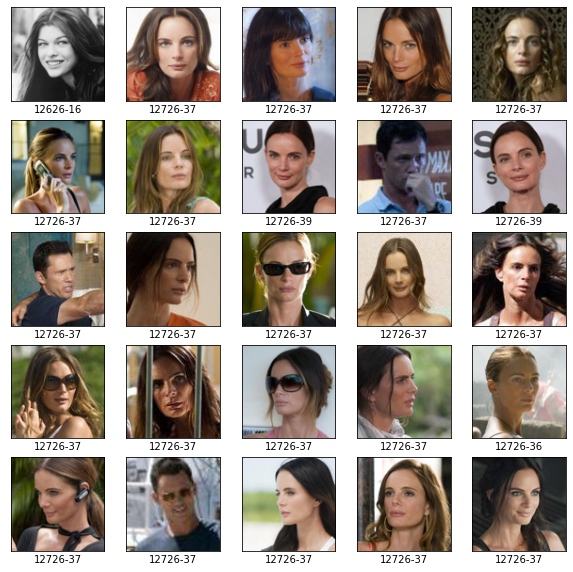

In [10]:
# Viewing of the sample images
plt.figure(figsize=(10,10))
offset = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_x_data[i+offset], cmap=plt.cm.binary)
    plt.xlabel(val_y_data[i+offset])
plt.show()

### **Normalize the input x data**

In [55]:
#normalize the data
train_x_data = train_x_data/255.0
val_x_data = val_x_data/255.0
test_x_data = test_x_data/255.0

### **Feature Extraction**

For extracting features from the facial images, Histogram of Oriented Gradients, also know as HOG is used, which is used in image processing for object detection. 

#### **Function to convert rgb to gray**

In [56]:
# Convert RGB image to gray image
def rgb2gray(rgb):
  '''
  Returns the gray version of the image.
  Parameters:
  rgb(image_array): RGB image array
  Returns:
  gray (image_array): Numpy array of gray image
  '''
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

#### **HOG Featuirizer**

In [57]:
# Extract features of image through HOG
def preprocess_x_data_using_HOG(x):
  '''
  Returns gray image, hog_features and hog_image from hog modules.
  It also call the function that convert rgb image to gray
  Using the matrix that Skimage's hog function returns, the gradients can be visualized.
  Parameters:
  x(array) : Array of a single image
  Returns:
  hog_feature: features from hog
  hog_image (image_array): output image from hog
  '''
  gray_x = rgb2gray(x)
  hog_feature,hog_image = hog(gray_x, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
  return gray_x, hog_feature, hog_image

In [58]:
def create_feature_of_multiple_images(train_data):
  '''Returns gray image, hog features and image for the list of images passed'''
  grays=[]
  features=[]
  hog_images = []
  for i in train_data:
    gray_x, hog_feature, hog_image = preprocess_x_data_using_HOG(i)
    grays.append(gray_x)
    features.append(hog_feature)
    hog_images.append(hog_image)
  return grays, features, hog_images


#### **Create DataFrame**

Create a new dataframe to hold all filenames: image_id, exact_age, and age_group.

In [59]:
# Converting the numpy arrays to pandas dataframe
def create_df(age_data,age_groups, label_data):
  '''
  Create Dataframe of image_id, exact_age and age_group
  Parameters:
  age (array) : Exact age 
  label (array) :Unique image id
  age_bucket(array) : Bucketing of age 
  '''
  df = pd.DataFrame()
  df['age_bucket'] = np.array(age_groups)
  df['exact_age'] = np.array(age_data)
  df['image_label'] = np.array(label_data)
  return df

#### **Call the gray conversion and HOG function**

In [16]:
# Create HOG Features on Train, Test and Validation X data
gray_x_train, hog_feature_x_train, hog_image_x_train = create_feature_of_multiple_images(train_x_data)
gray_x_test, hog_feature_x_test, hog_image_x_test = create_feature_of_multiple_images(test_x_data)
gray_x_val, hog_feature_x, hog_image_x_val = create_feature_of_multiple_images(val_x_data)


#### **Preprocess Y Train Data**

In [17]:
# Separate age and label for train data
age_y_train, label_y_train = age_and_id(train_y_data)
# Create bucket of 0,1,2 according to exact age
age_group_y_train = create_bucket(age_y_train)
# Create dataframe
df_y_train = create_df(age_y_train, age_group_y_train, label_y_train)
#Reshaping output 
train_y_label = reshape_bucket(df_y_train)

#### **Preprocess Y Validation Data**

In [18]:
# Separate age and label for train data
age_y_val, label_y_val = age_and_id(val_y_data)
# Create bucket of 0,1,2 according to exact age
age_group_y_val = create_bucket(age_y_val)
# Create dataframe
df_y_val = create_df(age_y_val, age_group_y_val, label_y_val)
#Reshaping output 
val_y_label = reshape_bucket(df_y_val)

##  **A. Classification using C-Support Vectors.**

LibSVM is the foundation of the implementation. Beyond tens of thousands of data, the fit time may become problematic and scales at least quadratically with the number of samples. *italicised text*

In [19]:
# instantiate classifier
classification_model = svm.SVC()

**Fit the SVM Model**

In [20]:
# fit classifier to training set
classification_model.fit(hog_feature_x_train,train_y_label)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [21]:
# Saving the model
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/Project/SVM_model.sav'
pickle.dump(classification_model, open(filename, 'wb'))

### **Performance of Model Trained**
Calcualte Y using X validation Data

In [22]:
def calculate_accuracy_score_validation(hog_feature,val_y,classification_model):
  '''
  Predict for the validation data and assess the accuracy
  '''
  # make predictions on test set
  y_pred = classification_model.predict(hog_feature)
  acc_score = accuracy_score(val_y, y_pred)

  #display accuracy of the model
  print("Accuracy: "+str(acc_score))
  print('\n')
  y_predicted = (classification_report(val_y, y_pred))
  return y_pred,acc_score,y_predicted

In [23]:
def create_df_for_test_data(test_data, model, path_to_save):
  '''Create Dataframe for prediction on Test Set'''
  y = model.predict(test_data)
  df_pred = pd.DataFrame(np.array(y),columns = ['prediction'])
  df_pred['prediction'].to_csv(path_to_save)
  return y

In [24]:
y_pred_svm,acc_score_svm,y_predicted_svm = calculate_accuracy_score_validation(hog_feature_x, val_y_label,classification_model)

Accuracy: 0.5988439306358382




In [25]:
# display accuracy of the model
print('CLassication Report from SVM:',y_predicted_svm)

CLassication Report from SVM:               precision    recall  f1-score   support

           0       0.52      0.27      0.35       529
           1       0.63      0.81      0.71      1479
           2       0.52      0.36      0.42       587

    accuracy                           0.60      2595
   macro avg       0.55      0.48      0.50      2595
weighted avg       0.58      0.60      0.57      2595



In [26]:
y_svm_test = create_df_for_test_data(hog_feature_x_test,classification_model,"/content/drive/MyDrive/Colab Notebooks/Project/46864512-conv-svm-normalized.csv")

Accuracy from the SVM is 59 %.

**Test the accuracy with Random Forerest also with HOG features**



## **B. RandomForest Classifier**

After many decision tree classifiers have been fitted to various dataset subsamples, a random forest is a meta estimator that uses averaging to improve predicted accuracy and decrease overfitting.

In [27]:
# instantiate classifier with 
classification_model_2 = RandomForestClassifier()

# fit classifier to HOG training set
classification_model_2.fit(hog_feature_x_train,train_y_label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier()

In [28]:
filename = '/content/drive/MyDrive/Colab Notebooks/Project/RandomForest_model.sav'
pickle.dump(classification_model_2, open(filename, 'wb'))


In [29]:
# make predictions on test set
y_pred_rf,acc_score_rf,y_predicted_rf = calculate_accuracy_score_validation(hog_feature_x, val_y_label,classification_model_2)

Accuracy: 0.5919075144508671




In [30]:
# display accuracy of model
print('CLassication Report from SVM:',y_predicted_rf)

CLassication Report from SVM:               precision    recall  f1-score   support

           0       0.59      0.16      0.25       529
           1       0.60      0.90      0.72      1479
           2       0.50      0.22      0.31       587

    accuracy                           0.59      2595
   macro avg       0.56      0.42      0.42      2595
weighted avg       0.58      0.59      0.53      2595



In [31]:
y_rf_test = create_df_for_test_data(hog_feature_x_test,classification_model_2,"/content/drive/MyDrive/Colab Notebooks/Project/46864512-conv-rf-normalized.csv")

### **Discussion**

* As SVM seeks to maximize "margin," it is dependent on the idea of "distance" 
between various places. A intermediary stage in SVM is creating an n-by-n matrix by computing the n2 dot products if your data consists of n points and m features (consider the amount of memory needed for storage) (computational complexity). SVM can therefore only really scale up to 105 points, on average. Large numbers of characteristics, such as those that are homogeneous and have significant distances (one image pixel would be a perfect example), are typically not an issue. 
* Random Forest provides you with the likelihood of belonging to a class for a classification issue. SVM provides the distance to the border; but, if you need probability, you still need to transform it in some other way.
* When applied to such issues, SVM typically outperforms Random Forest. The "support vectors" provided by SVM are the points in each class that are most near the class boundary.
* Accuracy of SVM with hog_features and without hog features(MinMaxscaling)
are * Accuracy of SVM with hog_features and without hog features(MinMaxscaling) are 59 % and   58% resoectively
* Accuracy of Random Forest with hog_features and without hog features(MinMaxscaling)are 58 % and 
* Accuracy of SVM with hog_features and without hog features(MinMaxscaling)
are 59 % and respectively.
* Accuracy is higher for SVM model than the Random Forest Classifier that is 59 % and 58 % respectivelty
* Likewise the precision for label 1 is better on SVM model but the recall one is better on the RF model.

#**2. Deep Learning approach:**

Second, numerous deep learning model is implemented using the *tensorflow* library along with data augmentation and without augmentation. Similarly, a model with CNN layers is used. 

Among the two models, the final model which produced the best performing prediction model is ..............according to the Kaggle submission with the accuaracy of ........

### **Import necessary libraries**

In [60]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

### **Pre process the data:**

Lets look at the data first and see how many datas are in each group

In [61]:
group_age = df_y_train.groupby("age_bucket")
  
# count the observations
df_count = group_age.count()
df_count


,exact_age,image_label
age_bucket,,
0,3361,3361
1,6391,6391
2,3723,3723


In [62]:
df_y_train

,age_bucket,exact_age,image_label
0,2,81,12466
1,2,61,12466
2,2,81,12466
3,2,61,12466
4,1,35,12566
...,...,...,...
13470,0,14,2231795
13471,0,14,2231795
13472,0,19,2366695
13473,0,20,2761495


In [63]:
df_count['Age_groups'] = df_count.index


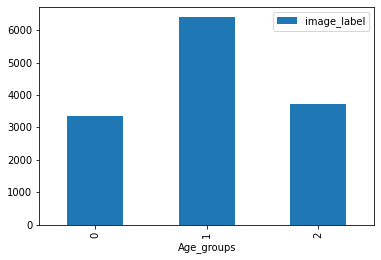

In [64]:
grp_plot = df_count.plot.bar(x = 'Age_groups' , y='image_label')

As we can see, 0 and 2 groups have less data than group 1. Many unique id's have different exact age. So, we will average it and count the age buckets. 

In [65]:
group_images = df_y_train.groupby("image_label")
group_images.count()

,age_bucket,exact_age
image_label,,
1004266,6,6
100583,14,14
1005869,2,2
1006994,2,2
100969,1,1
...,...,...
974193,2,2
97683,1,1
97768,55,55


We can conclude from above dataframe that one image_label has multiple exact ages, lets average the exact then recalculate age_bucket and see the number of images that falls in each group

In [66]:
# check the datatype of the variables
df_y_train.dtypes

age_bucket      int64
exact_age       int64
image_label    object
dtype: object

In [67]:
# Convert the exact_age into int type
df_y_train['exact_age']= df_y_train['exact_age'].astype('int')

In [68]:
# averaging with mean()
average_age = df_y_train.groupby("image_label").mean()
average_age

,age_bucket,exact_age
image_label,,
1004266,1.0,37.166667
100583,0.0,15.928571
1005869,0.0,6.000000
1006994,1.0,38.000000
100969,1.0,37.000000
...,...,...
974193,0.0,20.000000
97683,1.0,35.000000
97768,1.0,37.363636


In [69]:
# Create the new bucket with data exact_age
bucket = create_bucket(average_age['exact_age'])

In [70]:
# store the new average_age of the exact_age into the bucket
average_age['bucket_age_after_averaging'] = bucket

In [71]:

del average_age['age_bucket']
del average_age['exact_age']

In [72]:
average_age

,bucket_age_after_averaging
image_label,
1004266,1
100583,0
1005869,0
1006994,1
100969,1
...,...
974193,0
97683,1
97768,1


In [73]:
# mapping 
dict_map_id_to_bucket = (average_age.to_dict('index'))

In [74]:
df_y_train['image_label']


0          12466
1          12466
2          12466
3          12466
4          12566
          ...   
13470    2231795
13471    2231795
13472    2366695
13473    2761495
13474    3021195
Name: image_label, Length: 13475, dtype: object

In [75]:
age_after_average = []
for j in range(len(df_y_train)):
  for keys in dict_map_id_to_bucket.keys():
    if df_y_train['image_label'][j]==keys:
      age_after_average.append((dict_map_id_to_bucket.get(keys)).get('bucket_age_after_averaging'))

In [76]:
# check the len after average
len(age_after_average)

13475

In [77]:
df_y_train['age_bucket_after_averaging'] = age_after_average
df_y_train

,age_bucket,exact_age,image_label,age_bucket_after_averaging
0,2,81,12466,2
1,2,61,12466,2
2,2,81,12466,2
3,2,61,12466,2
4,1,35,12566,1
...,...,...,...,...
13470,0,14,2231795,0
13471,0,14,2231795,0
13472,0,19,2366695,0
13473,0,20,2761495,0


In [78]:
group_avergae_age = df_y_train.groupby("age_bucket_after_averaging")
  
# count the observations
df_avg_count = group_avergae_age.count()


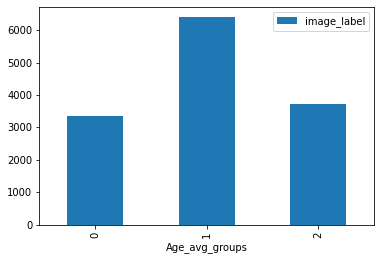

In [79]:
df_avg_count['Age_avg_groups'] = df_avg_count.index
grp_avg_plot = df_avg_count.plot.bar(x = 'Age_avg_groups' , y='image_label')

### **Image count**:

Image count before averaging

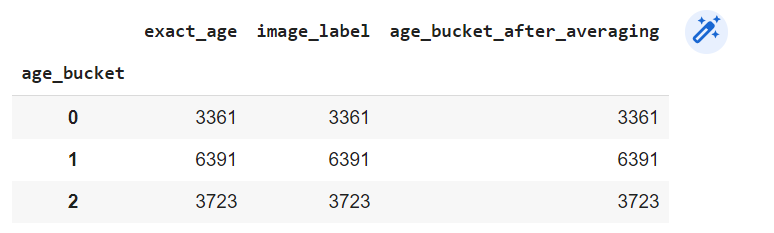

Image count after averaging


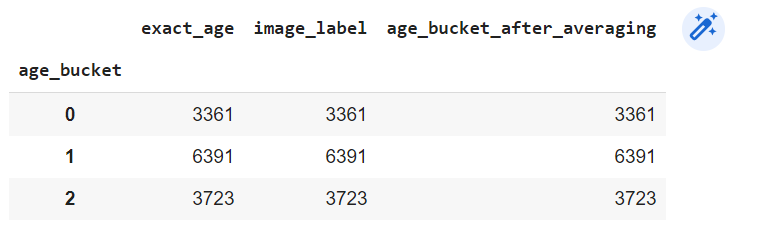


As both the counts are same, hence exact age may be different for unique image id but the bucket is same even after averaging

In [80]:
df_y_train

,age_bucket,exact_age,image_label,age_bucket_after_averaging
0,2,81,12466,2
1,2,61,12466,2
2,2,81,12466,2
3,2,61,12466,2
4,1,35,12566,1
...,...,...,...,...
13470,0,14,2231795,0
13471,0,14,2231795,0
13472,0,19,2366695,0
13473,0,20,2761495,0


## **A. Train Model with Augmentation**


*   Implement Horizontal and Vertical Flip Augmentation
*   Random Rotation Augmentation 

The justification for this is that adding more data to the model's training set would assist the dataset's variance rise. This may reduce the likelihood of over-fitting while increasing the model's accuracy.

In [81]:
train_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/train_images.npy')
train_y_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/train_labels.npy')
val_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/val_images.npy')
val_y_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-mproject/val_labels.npy')
test_x_data = read_npy_data('/content/drive/MyDrive/Colab Notebooks/Project/facial-age-class-recognition-private-mproject/test_priv_images.npy')


### **Preprocess Y train data**

In [82]:
# Separate age and label for train data
age_y_train, label_y_train = age_and_id(train_y_data)
# Create bucket of 0,1,2 according to exact age
age_group_y_train = create_bucket(age_y_train)
# Create dataframe
df_y_train = create_df(age_y_train, age_group_y_train, label_y_train)
#Reshaping output 
train_y_label = reshape_bucket(df_y_train)

### **Preprocess Y validtaion data**

In [83]:
# Separate age and label for train data
age_y_val, label_y_val = age_and_id(val_y_data)
# Create bucket of 0,1,2 according to exact age
age_group_y_val = create_bucket(age_y_val)
# Create dataframe
df_y_val = create_df(age_y_val, age_group_y_val, label_y_val)
#Reshaping output 
val_y_label = reshape_bucket(df_y_val)

### **Resize and Normalize the Data**

In [84]:

IMG_SIZE = 100
## Becuase Pixel range in Images are between [0,255], To rescale an input in the [0, 255] range
# to be in the [0, 1] range, you would pass scale=1./255
resize_and_rescale = tf.keras.Sequential([
            layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE, input_shape=[100,100,3]),
            layers.experimental.preprocessing.Rescaling(1./255)
])

Augment Images with Horizontal, Vertical Flips and Rotations

In [85]:

data_augmentation = tf.keras.Sequential([
                            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            layers.experimental.preprocessing.RandomRotation((-0.2, 0.3)),
])

Define Model Structure with Augmentation

The architecture of our CNN model

* Conv2D layer –   convolutional layers of 8 filters, size of 3, and activation as relu

* Max Pooling – MaxPool2D

* Conv2D layer –   convolutional layers of 16 filters, size of 3, and activation as relu

* Max Pooling – MaxPool2D

* Conv2D layer –   convolutional layers of 32filters, size of 3, and activation as relu

* Max Pooling – MaxPool2D

* Flattenn layer to squeeze the layers into 1 dimension

* Dense, feed-forward neural network(64 nodes, activation=”relu”)

* Dense –  for feed-forward neural network

In [86]:
# Defining the architecture of the sequential neural network.
model = tf.keras.models.Sequential([
                                   resize_and_rescale,
                                   data_augmentation,
                                   tf.keras.layers.Conv2D(filters=8, kernel_size = 3, activation='relu', padding='same'),
                                   tf.keras.layers.MaxPooling2D(),
                                   tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
                                   tf.keras.layers.MaxPooling2D(),
                                    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
                                   tf.keras.layers.MaxPooling2D(),
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(units=64, activation = 'relu'),
                                   tf.keras.layers.Dense(units = 3, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                  

## **Split Dataset into train and test:**

Data is splitted into 90% and 10% for train and test data respectively. 

In [87]:
train_data,test_data,train_target,test_target=train_test_split(train_x_data,train_y_label,test_size=0.1)

In [88]:
train_target

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [2]])

In [89]:
test_target

array([[1],
       [1],
       [0],
       ...,
       [1],
       [2],
       [2]])

#### Compile Model with RMSprop and train model till 205 epochs

In [90]:
# Compiling the neural network defined above.
model.compile(loss="sparse_categorical_crossentropy", optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [92]:
# Defining the early stop to monitor the validation loss to avoid overfitting.
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [93]:
# fitting the model
history = model.fit(train_data, train_target, epochs=205, validation_data=(test_data, test_target))

Epoch 1/205
379/379 [==============================] - 89s 232ms/step - loss: 1.0542 - accuracy: 0.4714 - val_loss: 1.0215 - val_accuracy: 0.5059
Epoch 2/205
379/379 [==============================] - 88s 231ms/step - loss: 1.0319 - accuracy: 0.4761 - val_loss: 1.0072 - val_accuracy: 0.5074
Epoch 3/205
379/379 [==============================] - 91s 240ms/step - loss: 1.0203 - accuracy: 0.4837 - val_loss: 1.0015 - val_accuracy: 0.5178
Epoch 4/205
379/379 [==============================] - 88s 231ms/step - loss: 1.0099 - accuracy: 0.4980 - val_loss: 0.9614 - val_accuracy: 0.5401
Epoch 5/205
379/379 [==============================] - 88s 233ms/step - loss: 1.0007 - accuracy: 0.5031 - val_loss: 0.9625 - val_accuracy: 0.5274
Epoch 6/205
379/379 [==============================] - 88s 232ms/step - loss: 0.9935 - accuracy: 0.5057 - val_loss: 0.9661 - val_accuracy: 0.5148
Epoch 7/205
379/379 [==============================] - 88s 232ms/step - loss: 0.9878 - accuracy: 0.5080 - val_loss: 0.9437 -

KeyboardInterrupt: ignored

#### **Save the model to drive**

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Project/Concv.h5')

#### **Plot the train and validation accuracy**




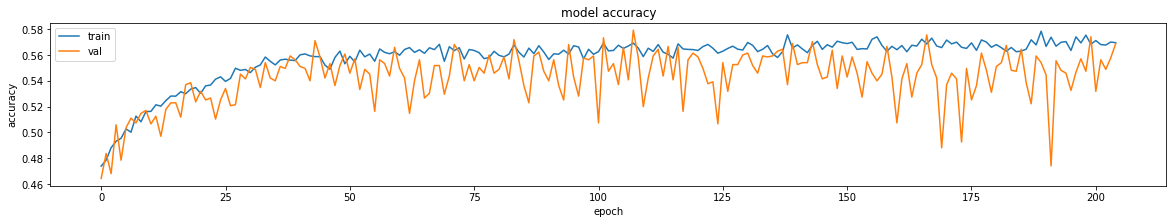

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 167 have 0.48 validation accuracy.

---
Test accuracy is highly fluctuating than train accuracy.

**Train Accuracy : 58.45%**

**Test Accuracy: 62.43%**

PLot training and validation loss

Training loss is gradually decreasing but the validation loss is fluctuating

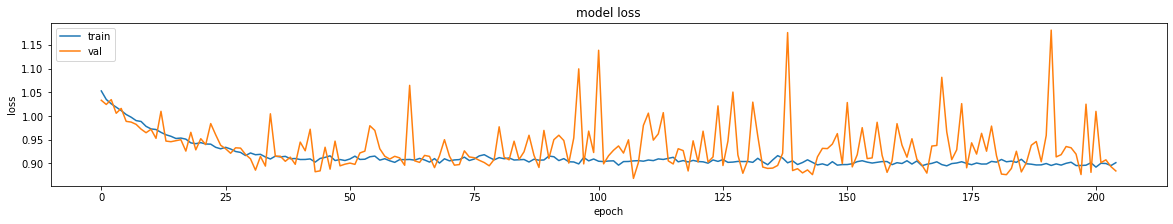

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load Model to Predict on provided validation data and test data

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Project/Concv.h5')

In [ ]:
def predict(model, x):
  y_pred = model.predict(x)
  y_prediction =[]
  for i in y_pred:
    result = np.where(i == np.amax(i))
    y_prediction.append((result[0]))
  return y_prediction



In [ ]:
y = predict(model,val_x_data)

82/82 [==============================] - 0s 4ms/step


On Validation Data,

Precision is 0.49 for class 0, 0.67 for 1 and 0.6 for 2

Accuracy is 62%

In [ ]:
print(classification_report(val_y_label, y))

              precision    recall  f1-score   support

           0       0.44      0.59      0.50       529
           1       0.69      0.61      0.65      1479
           2       0.50      0.48      0.49       587

    accuracy                           0.58      2595
   macro avg       0.54      0.56      0.55      2595
weighted avg       0.59      0.58      0.58      2595



In [ ]:
def create_df_for_test_data_from_cnn(test_data, model, path_to_save):
  '''Create Dataframe for prediction on Test Set'''
  y = predict(model, test_data)
  df_pred = pd.DataFrame(np.array(y),columns = ['prediction'])
  df_pred['prediction'].to_csv(path_to_save)
  return y

Predict  for test data and save the dataframe to drive in desired format

In [ ]:
y = create_df_for_test_data_from_cnn(test_x_data, model, "/content/drive/MyDrive/Colab Notebooks/Project/46864512-deep-CNN.csv")

75/75 [==============================] - 0s 4ms/step


In [ ]:
y

[array([1]),
 array([2]),
 array([2]),
 array([1]),
 array([2]),
 array([2]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([0]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([2]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([1]),
 array([2]),
 array([1]),
 array([2]),
 array([1]),
 array([2]),
 array([1]),

## **Discussion**

In deep learning model, I performed two models: DNN with augmentation and without augmentation. 

After training the model with augmentation and without augmentation, with first one is come to be the best model 

Some inference points: 

*   Accuracy of model with augmentation is 62% and without augmentation is 57%
*   Augmentation helped to expand the dataset space and helps model to train better
* The result on test data have better performance with augmentation.

### **Compairsion between conventional ML and Deep Learning models:**

After training the model with conventional ML and Deep Learning with the provide public test set, the deep learning performed better with the accuracy of ..... which is more than the conventional of ...... 

The deep learning model ranked #11 out of 30 submissions on the public test set, with the top-performing system having 78%, and a majority class baseline having 52% accuracy. 




